In [1]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import keras 
from tqdm import tqdm
from keras.callbacks import EarlyStopping,ModelCheckpoint
from sklearn.metrics import confusion_matrix , accuracy_score
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')

In [2]:
#Create Files_Name
image_data='/kaggle/input/solar-panel-images/Faulty_solar_panel'
pd.DataFrame(os.listdir(image_data),columns=['Files_Name'])

Files_Name
0       Snow-Covered
1              Dusty
2  Electrical-damage
3              Clean
4          Bird-drop
5    Physical-Damage

In [3]:
train_data_dir =image_data
batch_size = 32
target_size = (224,224)
validation_split = 0.2
train= tf.keras.preprocessing.image_dataset_from_directory(
    train_data_dir,
    validation_split=validation_split,
    subset="training",
    seed=100,
    image_size=target_size,
    batch_size=batch_size,
)
validation= tf.keras.preprocessing.image_dataset_from_directory(
    train_data_dir,
    validation_split=validation_split,
    subset="validation",
    seed=200,
    image_size=target_size,
    batch_size=batch_size,
)

Found 885 files belonging to 6 classes.
Using 708 files for training.
Found 885 files belonging to 6 classes.
Using 177 files for validation.


In [4]:
class_names = train.class_names
class_names

['Bird-drop',
 'Clean',
 'Dusty',
 'Electrical-damage',
 'Physical-Damage',
 'Snow-Covered']

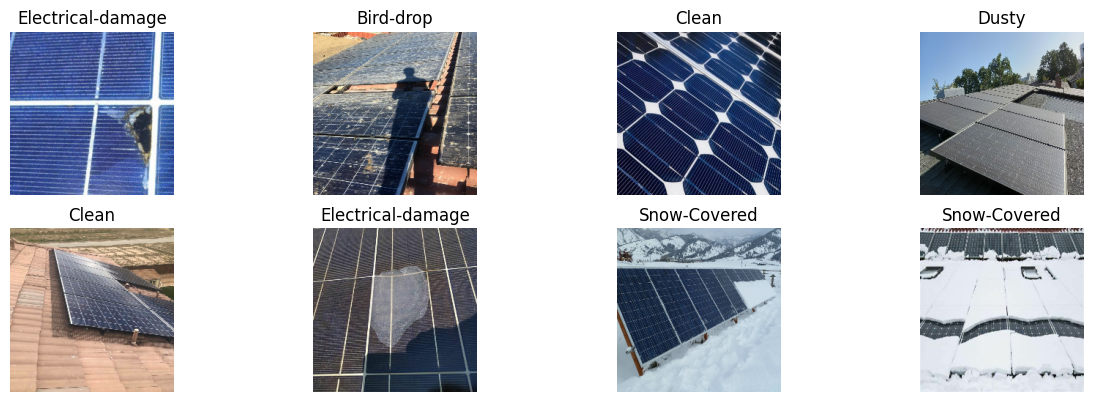

In [5]:
plt.figure(figsize=(15, 20))
for images, labels in train.take(1):
    for i in range(8):
        ax = plt.subplot(8, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [6]:
base_model = tf.keras.applications.MobileNetV3Small(input_shape=(224,224,3),include_top=False,weights='imagenet')
base_model.trainable = False
keras_model=keras.models.Sequential()
keras_model.add(base_model)
keras_model.add(keras.layers.Flatten()) 
keras_model.add(keras.layers.Dropout(0.5))
keras_model.add(keras.layers.Dense(6,activation=tf.nn.softmax))
keras_model.summary()

4334752/4334752 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 MobilenetV3small (Function  (None, 7, 7, 576)         939120    
 al)                                                             
                                                                 
 flatten (Flatten)           (None, 28224)             0         
                                                                 
 dropout (Dropout)           (None, 28224)             0         
                                                                 
 dense (Dense)               (None, 6)                 169350    
                                                                 
Total params: 1108470 (4.23 MB)
Trainable params: 169350 (661.52 KB)
Non-trainable params: 939120 (3.58 MB)
_________________________________________________________________


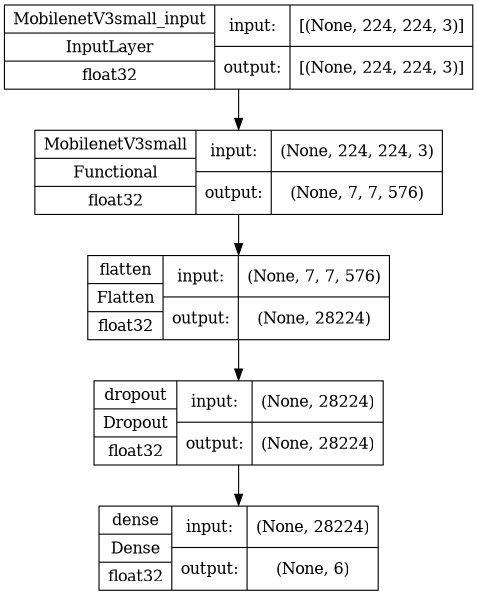

In [7]:
tf.keras.utils.plot_model(keras_model, to_file='model.png', show_shapes=True, show_layer_names=True,show_dtype=True,dpi=80)

In [8]:
checkpoint =ModelCheckpoint("my_keras_model.h5", save_best_only=True)


In [9]:
early_stopping =EarlyStopping(patience=5, restore_best_weights=True)


In [10]:
keras_model.compile(optimizer ='adam',loss='sparse_categorical_crossentropy', metrics=['accuracy'])
hist=keras_model.fit_generator(train,epochs=10,validation_data=validation,callbacks=[checkpoint,early_stopping])

Epoch 1/10
23/23 [==============================] - 15s 415ms/step - loss: 3.7035 - accuracy: 0.4689 - val_loss: 0.5906 - val_accuracy: 0.8814
Epoch 2/10
23/23 [==============================] - 10s 343ms/step - loss: 0.8290 - accuracy: 0.8489 - val_loss: 0.5103 - val_accuracy: 0.9096
Epoch 3/10
23/23 [==============================] - 9s 326ms/step - loss: 0.3128 - accuracy: 0.9308 - val_loss: 0.2645 - val_accuracy: 0.9492
Epoch 4/10
23/23 [==============================] - 9s 324ms/step - loss: 0.1666 - accuracy: 0.9520 - val_loss: 0.1921 - val_accuracy: 0.9435
Epoch 5/10
23/23 [==============================] - 9s 311ms/step - loss: 0.1113 - accuracy: 0.9816 - val_loss: 0.2558 - val_accuracy: 0.9492
Epoch 6/10
23/23 [==============================] - 10s 347ms/step - loss: 0.0792 - accuracy: 0.9873 - val_loss: 0.2656 - val_accuracy: 0.9492
Epoch 7/10
23/23 [==============================] - 9s 321ms/step - loss: 0.1035 - accuracy: 0.9831 - val_loss: 0.2300 - val_accuracy: 0.9492
Epo

In [11]:
hist_=pd.DataFrame(hist.history)
hist_

loss  accuracy  val_loss  val_accuracy
0  3.703470  0.468927  0.590592      0.881356
1  0.829050  0.848870  0.510337      0.909605
2  0.312761  0.930791  0.264486      0.949153
3  0.166622  0.951977  0.192081      0.943503
4  0.111334  0.981638  0.255752      0.949153
5  0.079159  0.987288  0.265606      0.949153
6  0.103475  0.983051  0.230012      0.949153
7  0.075271  0.990113  0.219677      0.954802
8  0.042081  0.990113  0.233195      0.943503

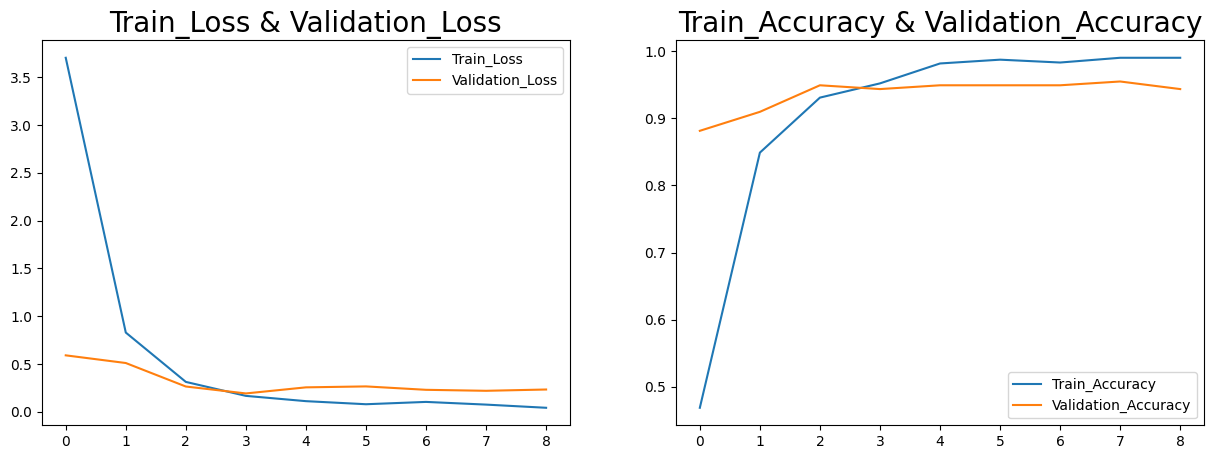

In [12]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(hist_['loss'],label='Train_Loss')
plt.plot(hist_['val_loss'],label='Validation_Loss')
plt.title('Train_Loss & Validation_Loss',fontsize=20)
plt.legend()
plt.subplot(1,2,2)
plt.plot(hist_['accuracy'],label='Train_Accuracy')
plt.plot(hist_['val_accuracy'],label='Validation_Accuracy')
plt.title('Train_Accuracy & Validation_Accuracy',fontsize=20)
plt.legend()

In [13]:
X_val,y_val,y_pred=[],[],[]
for images, labels in validation:
    y_val.extend(labels.numpy())
    X_val.extend(images.numpy())
predictions=keras_model.predict(np.array(X_val))
for i in predictions:
    y_pred.append(np.argmax(i))
df=pd.DataFrame()
df['Actual'],df['Prediction']=y_val,y_pred
df

6/6 [==============================] - 2s 137ms/step


Actual  Prediction
0         3           3
1         1           1
2         4           4
3         5           5
4         3           3
..      ...         ...
172       0           0
173       0           0
174       5           5
175       2           2
176       1           1

[177 rows x 2 columns]

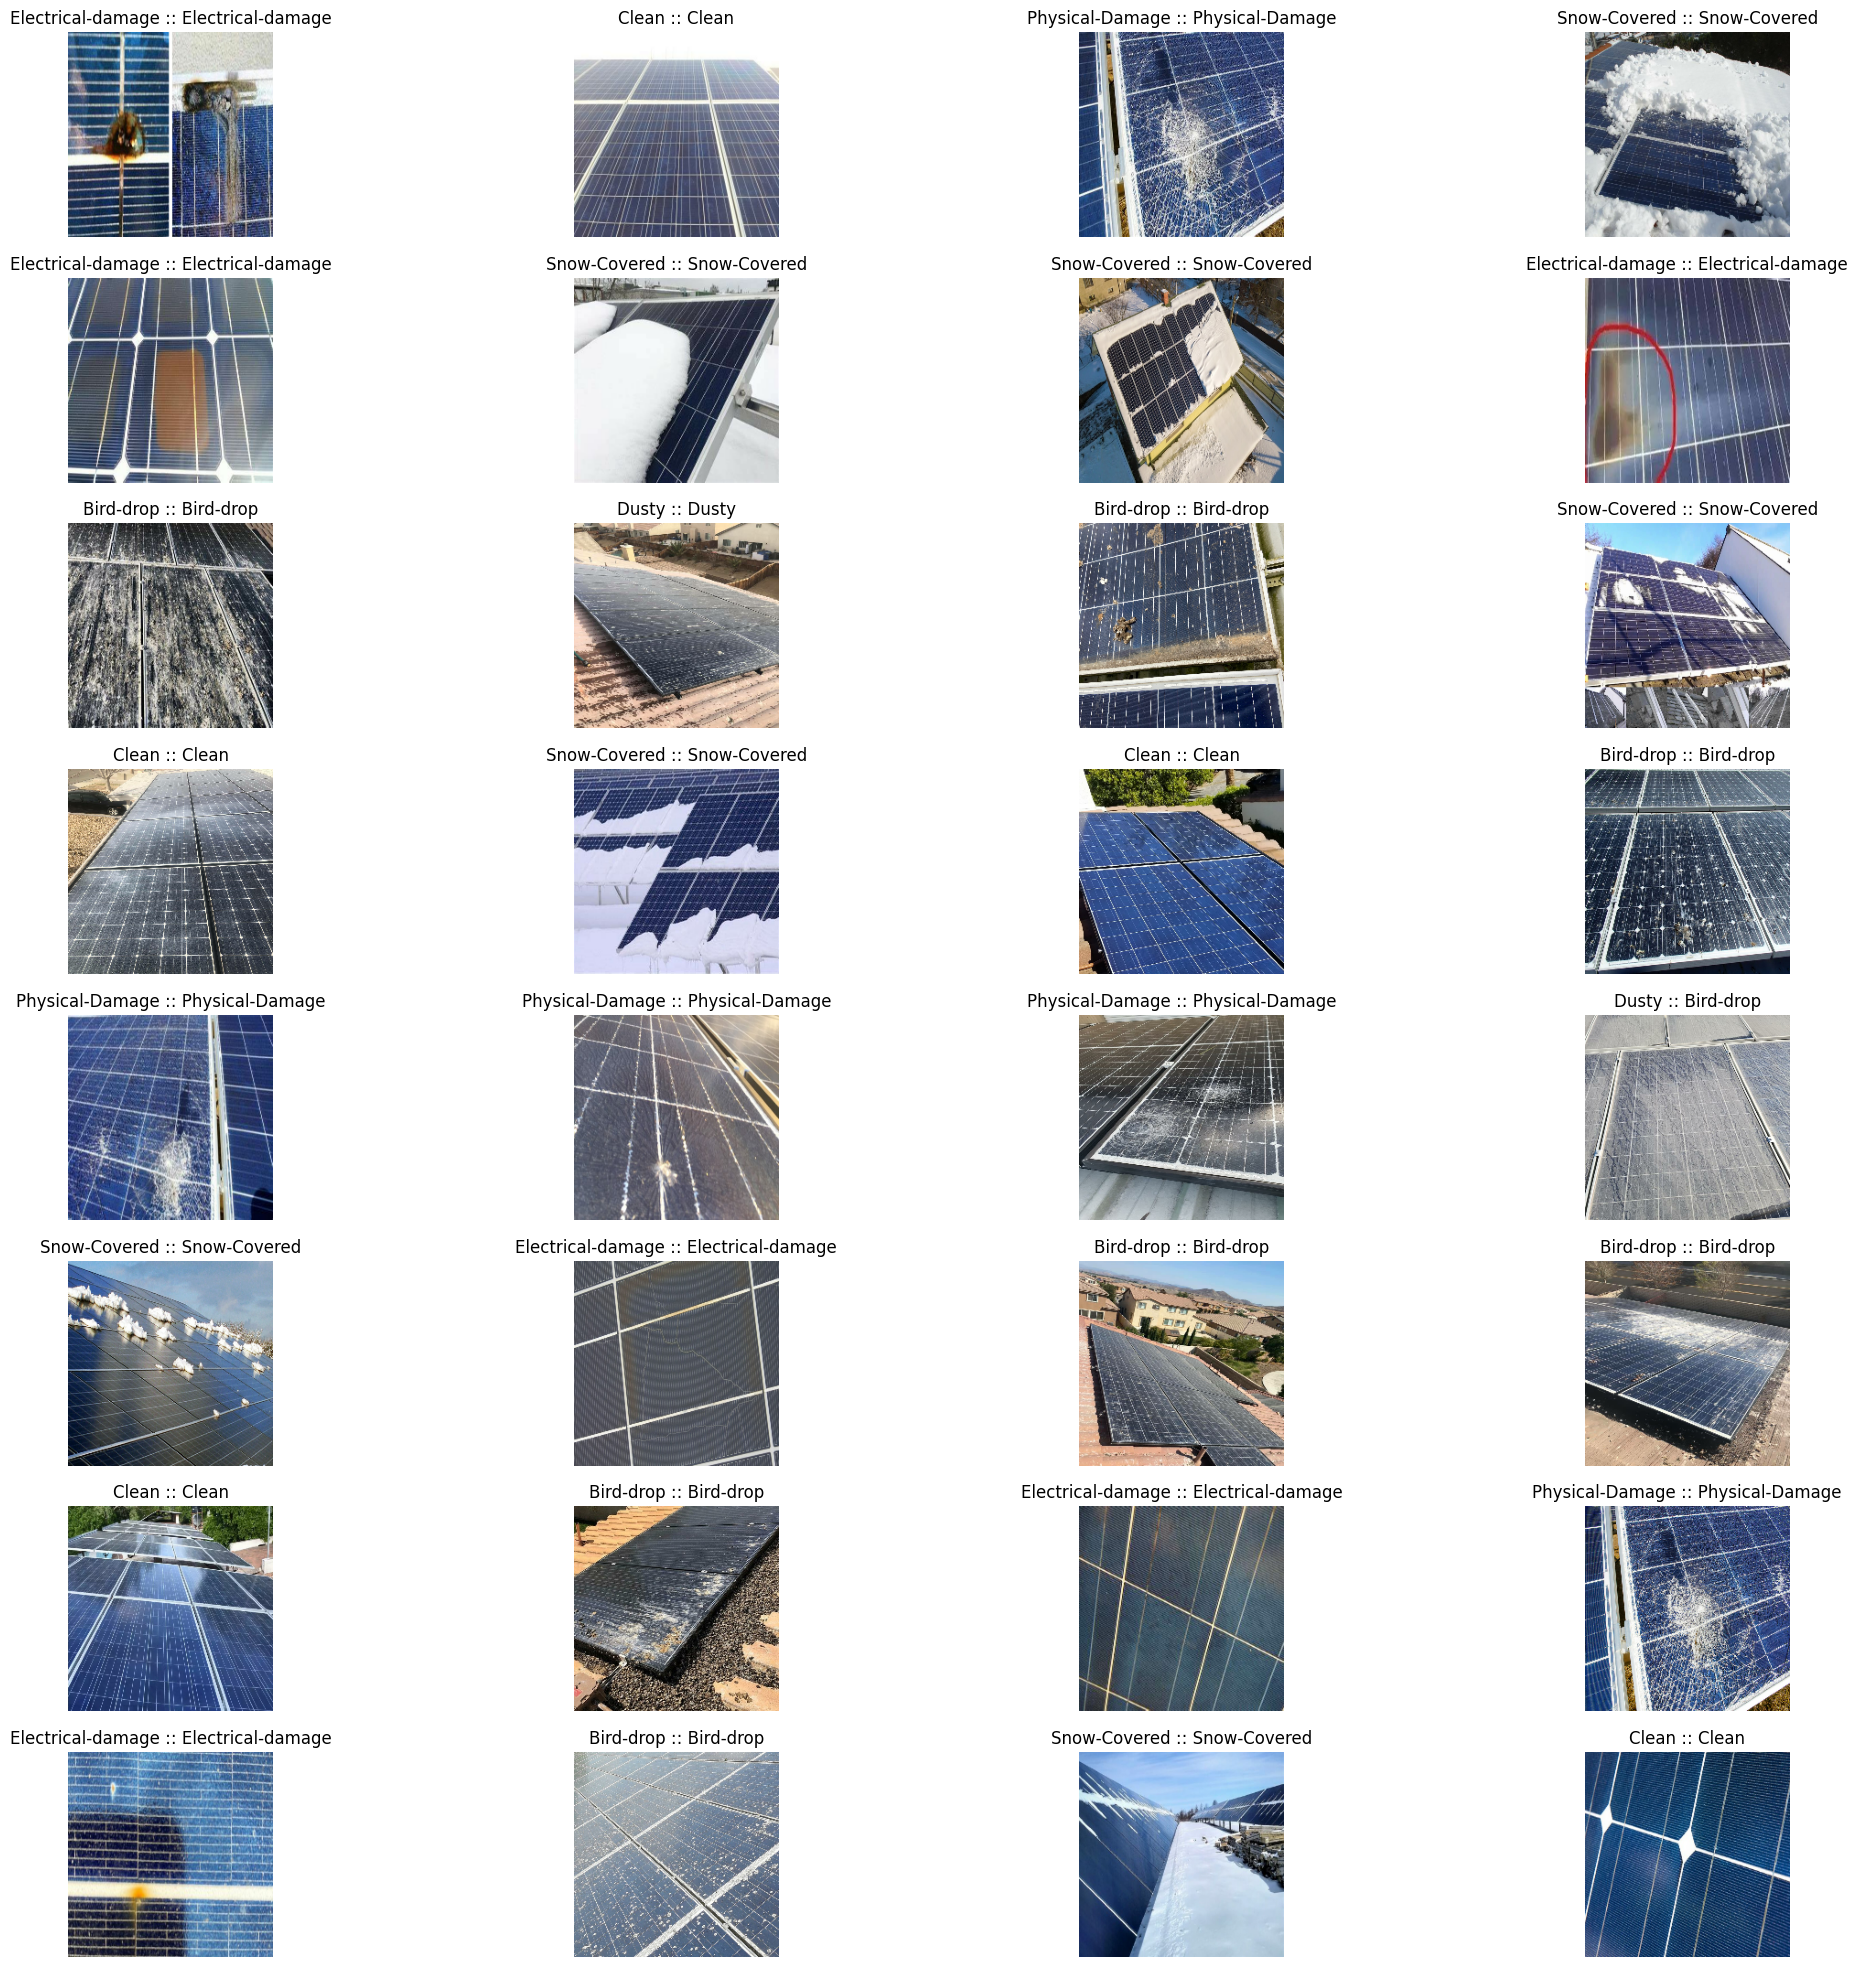

In [14]:
plt.figure(figsize=(25,25))
for i in range(32):
    ax = plt.subplot(8, 4, i + 1)
    plt.imshow(X_val[i].astype("uint8"))
    plt.title(f'{class_names[y_val[i]]} :: {class_names[y_pred[i]]}')
    plt.axis("off")

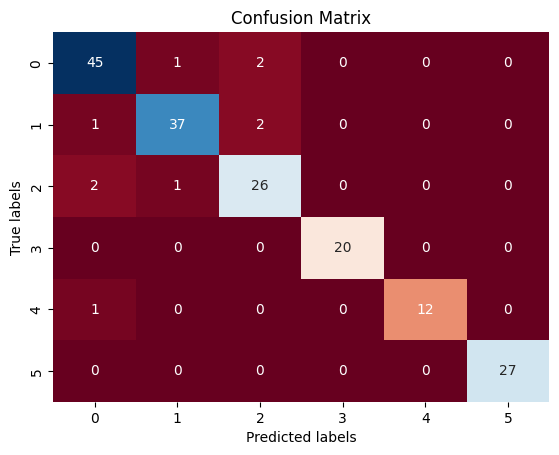

array([[45,  1,  2,  0,  0,  0],
       [ 1, 37,  2,  0,  0,  0],
       [ 2,  1, 26,  0,  0,  0],
       [ 0,  0,  0, 20,  0,  0],
       [ 1,  0,  0,  0, 12,  0],
       [ 0,  0,  0,  0,  0, 27]])

In [15]:
ax= plt.subplot()
CM = confusion_matrix(y_val,y_pred)
sns.heatmap(CM, annot=True, fmt='g', ax=ax,cbar=False,cmap='RdBu')
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels') 
ax.set_title('Confusion Matrix')
plt.show()
CM

In [16]:
Acc = accuracy_score(y_val,y_pred)
print("accuracy is: {0:.3f}%".format(Acc * 100))

accuracy is: 94.350%
